<a href="https://colab.research.google.com/github/VitorSRamos/ast503_2024_Fall/blob/main/homework/VitorRamos/Midterm/UNFINISHED_Midterm_ASTR503_VitorRamos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%matplotlib inline

In [32]:
!pip install trilogy --quiet

  Preparing metadata (setup.py) ... done


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from astropy.io import fits
from trilogy import trilogy

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy.

The point of this Midterm is to
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams:
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html)

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

In [ ]:
individual_plots=True # change this to true if you want to check each function individually

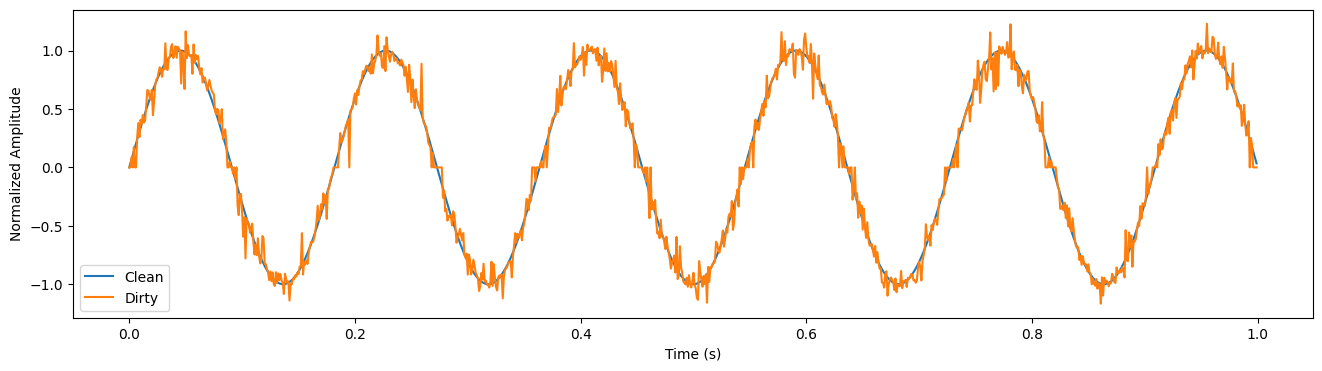

In [ ]:
def make_signal(frequency, endpoint, sampling_interval, noise_factor=0.1, seed=123):
    # frequency in Hz
    # endpoint is total time in seconds
    # sampling interval is given in seconds (measures signal every sampling_interval seconds)
    # noise factor determines how noisy the signal is (0 means clean signal)

    gen = np.random.RandomState(seed=seed)

    t = np.arange(0,endpoint,sampling_interval)
    signal = np.sin(2*np.pi*frequency*t)

    if noise_factor!=0: # avoids division by 0 errors
        noise = gen.normal(0, scale=noise_factor, size=len(signal)) # we generate a set of noise values sample from a gaussian centered on zero with std=noise_factor
        signal = np.round(signal/noise, decimals=1)*noise # then each point in signal is divided by its equivalent point in noise, rounded, and then multiplied by noise again

    return t, signal

if individual_plots:
    t_clean, signal_clean = make_signal(frequency=5.5, endpoint=1, sampling_interval=0.001, noise_factor=0)
    t_dirty, signal_dirty = make_signal(frequency=5.5, endpoint=1, sampling_interval=0.001, noise_factor=3)

    fig,ax = plt.subplots(figsize=(16,4))
    ax.plot(t_clean, signal_clean, label = "Clean")
    ax.plot(t_dirty, signal_dirty, label="Dirty")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Normalized Amplitude")
    ax.legend()

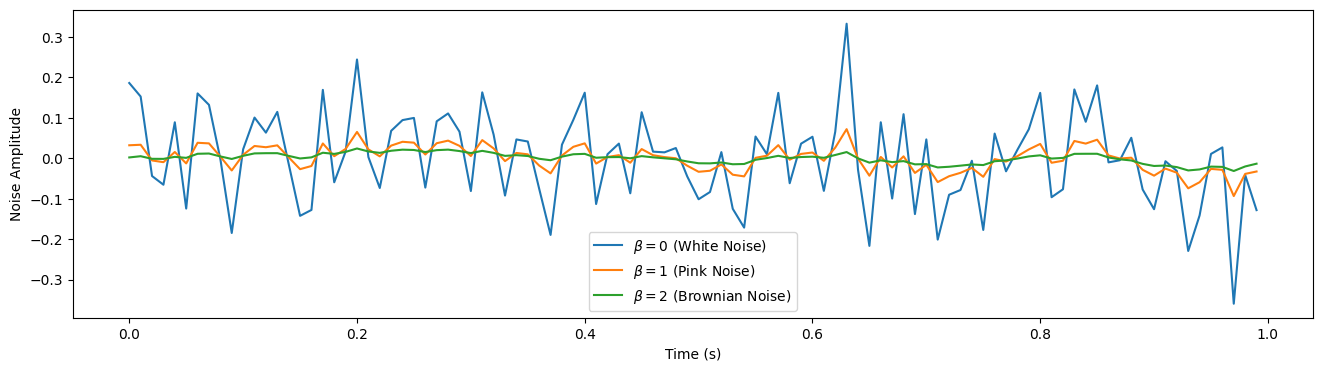

In [ ]:
def generate_noise(beta, N, seed=123):
    '''
    This function generates the power spectrum with 1/f**beta distribution and then inverse fourier transforms that into the time domain, as described in the provided link
    '''
    gen = np.random.RandomState(seed=seed) # for reproducibility

    # translating C code in reference pretty much verbatim to python
    real = np.zeros(N)
    imag = np.zeros(N)

    # Generate the noise signal
    for i in range(1, N // 2 + 1):
        mag = (i + 1.0) ** (-beta / 2) * gen.standard_normal()
        phase = 2*np.pi*gen.uniform()
        real[i] = mag * np.cos(phase)
        imag[i] = mag * np.sin(phase)
        real[N - i] = real[i]
        imag[N - i] = -imag[i]

    imag[N // 2] = 0

    # Documentation for reference's FFT can be found here: https://paulbourke.net/miscellaneous/dft/index.html
    # we use numpy to do it and take only the real part
    noise = np.fft.ifft(real+1j*imag)

    return noise.real

if individual_plots:
    endpoint = 1 # Seconds. Same values as other plot, but can be changed
    sampling_interval = 0.01 # same as above
    t = np.arange(0,endpoint,sampling_interval)
    N = len(t)

    fig, ax = plt.subplots(1,1, figsize=(16,4))
    ax.plot(t, generate_noise(N=N, beta=0), label = r"$\beta=0$ (White Noise)")
    ax.plot(t, generate_noise(N=N, beta=1), label = r"$\beta=1$ (Pink Noise)")
    ax.plot(t, generate_noise(N=N, beta=2), label = r"$\beta=2$ (Brownian Noise)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Noise Amplitude")
    ax.legend()

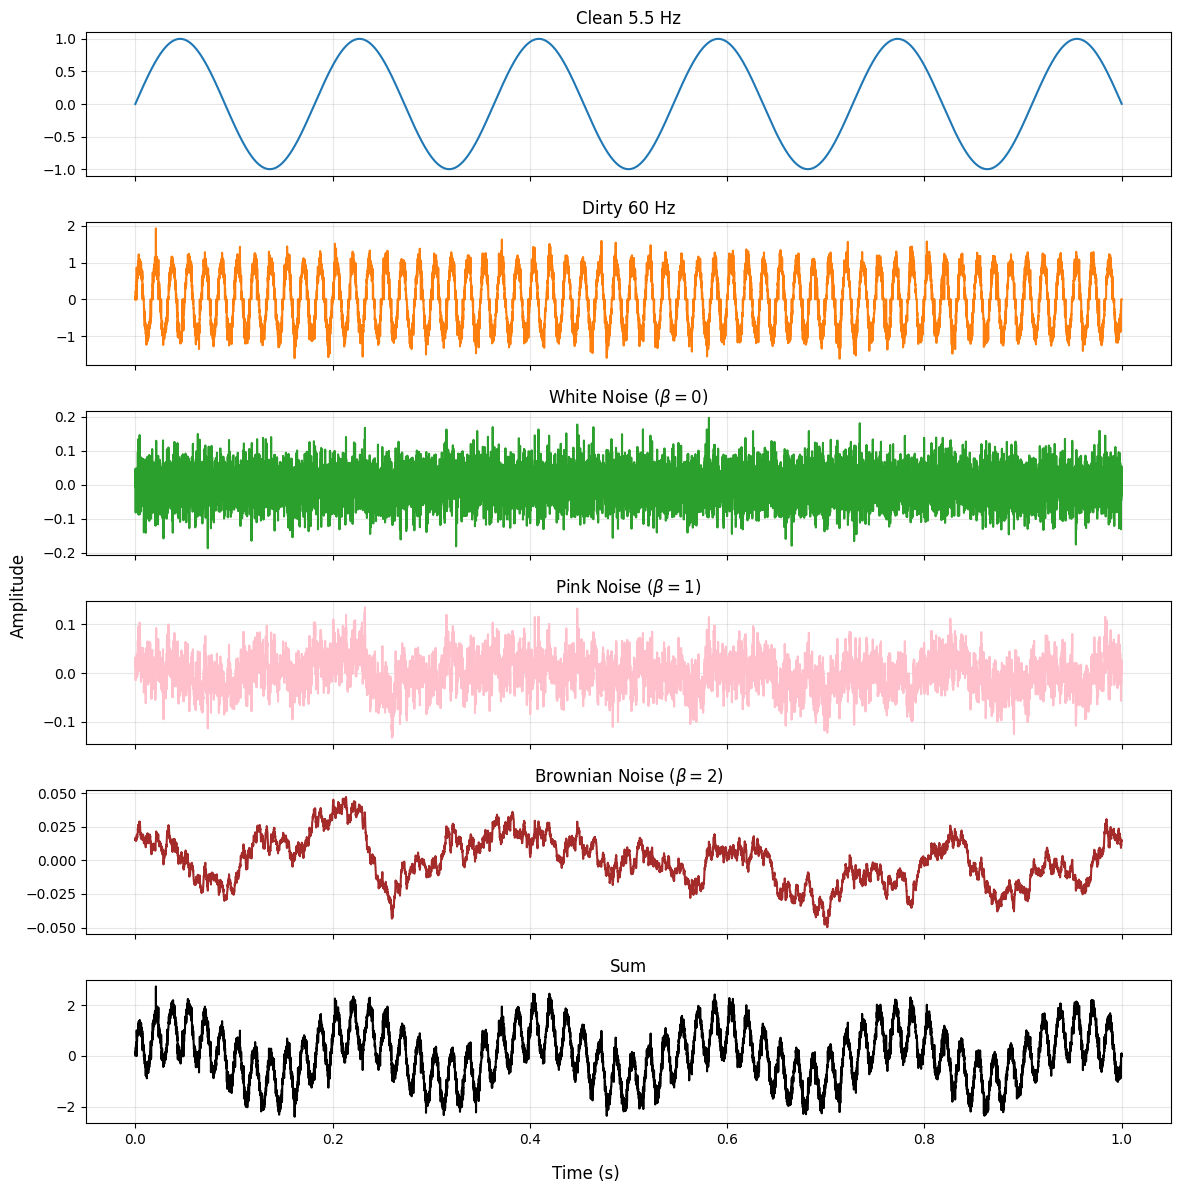

In [ ]:
# Plotting all time streams
endpoint=1 # in seconds
sampling_interval=0.0001 # in seconds
seed = 42

# time axis for noise components
t = np.arange(0,endpoint,sampling_interval)
N = len(t)

_, clean_5p5   = make_signal(frequency=5.5, endpoint=endpoint, sampling_interval=sampling_interval, noise_factor=0, seed=seed)
_, dirty_60    = make_signal(frequency=60, endpoint=endpoint, sampling_interval=sampling_interval, noise_factor=5, seed=seed)
white_noise    = 5  * generate_noise(beta=0, N=N, seed=seed) # scaled to make more evident
pink_noise     = 100 * generate_noise(beta=1, N=N, seed=seed) # scaled to make more evident
brownian_noise = 250 * generate_noise(beta=2, N=N, seed=seed) # scaled to make more evident
sum_of_all     = clean_5p5 + dirty_60 + white_noise + pink_noise + brownian_noise

fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)
axs[0].plot(t, clean_5p5, label="Clean 5.5 Hz", c="C0")
axs[0].grid(alpha=0.3)
axs[0].set_title("Clean 5.5 Hz")
#axs[0].legend()

axs[1].plot(t, dirty_60, label="Dirty 60 Hz", c="C1")
axs[1].grid(alpha=0.3)
axs[1].set_title("Dirty 60 Hz")
#axs[1].legend()

axs[2].plot(t, white_noise, label=r"White Noise ($\beta=0$)", c="C2")
axs[2].grid(alpha=0.3)
axs[2].set_title(r"White Noise ($\beta=0$)")
#axs[2].legend()

axs[3].plot(t, pink_noise, label=r"Pink Noise ($\beta=1$)", c="pink")
axs[3].grid(alpha=0.3)
axs[3].set_title(r"Pink Noise ($\beta=1$)")
#axs[3].legend()

axs[4].plot(t, brownian_noise, label=r"Brownian Noise ($\beta=2$)", c="brown")
axs[4].grid(alpha=0.3)
axs[4].set_title(r"Brownian Noise ($\beta=2$)")
#axs[4].legend()

axs[5].plot(t, sum_of_all, label="Sum", c="black")
axs[5].grid(alpha=0.3)
axs[5].set_title("Sum")
#axs[5].legend()

fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
plt.tight_layout()

Text(0, 0.5, 'Amplitude')

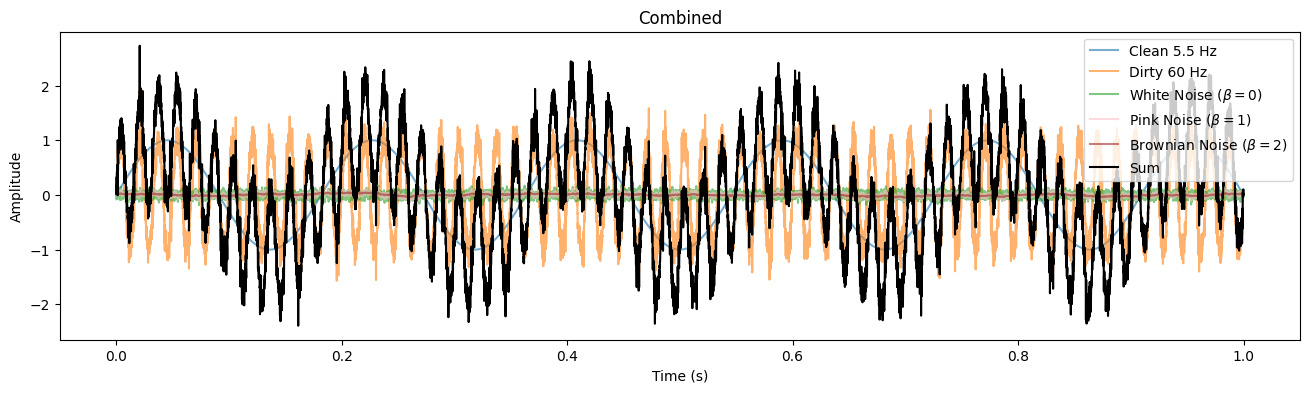

In [ ]:
# Alternatively, if you want a more chaotic plot
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(t, clean_5p5, label="Clean 5.5 Hz", c="C0", alpha=0.6)
ax.plot(t, dirty_60, label="Dirty 60 Hz", c="C1", alpha=0.6)
ax.plot(t, white_noise, label=r"White Noise ($\beta=0$)", c="C2", alpha=0.6)
ax.plot(t, pink_noise, label=r"Pink Noise ($\beta=1$)", c="pink", alpha=0.6)
ax.plot(t, brownian_noise, label=r"Brownian Noise ($\beta=2$)", c="brown", alpha=0.6)
ax.plot(t, sum_of_all, label="Sum", c="black", alpha=1)
ax.set_title("Combined")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")

In [ ]:
def count_outside_3sigma(arr):
    mean = np.mean(arr)
    sigma = np.std(arr)

    mask = (arr>mean+3*sigma) | (arr<mean-3*sigma) # returns true if if value is outside of 3 sigma interval around mean
    return sigma, np.sum(mask)

streams = {
    "Clean 5.5 Hz": clean_5p5,
    "Dirty 60 Hz": dirty_60,
    r"White Noise ($\beta=0$)": white_noise,
    r"Pink Noise ($\beta=1$)": pink_noise,
    r"Brownian Noise ($\beta=2$)": brownian_noise,
    "Sum of all": sum_of_all
}

for key,value in streams.items():
    sigma, count = count_outside_3sigma(value)
    print(f"For time stream {key:26} | The standard deviation is {sigma:.4f} |  There are {count:2} samples above or below 3 sigma | This corresponds to {100*count/len(value)}% of the stream.")

For time stream Clean 5.5 Hz               | The standard deviation is 0.7047 |  There are  0 samples above or below 3 sigma | This corresponds to 0.0% of the stream.
For time stream Dirty 60 Hz                | The standard deviation is 0.7264 |  There are  0 samples above or below 3 sigma | This corresponds to 0.0% of the stream.
For time stream White Noise ($\beta=0$)    | The standard deviation is 0.0499 |  There are 26 samples above or below 3 sigma | This corresponds to 0.26% of the stream.
For time stream Pink Noise ($\beta=1$)     | The standard deviation is 0.0356 |  There are 30 samples above or below 3 sigma | This corresponds to 0.3% of the stream.
For time stream Brownian Noise ($\beta=2$) | The standard deviation is 0.0175 |  There are  0 samples above or below 3 sigma | This corresponds to 0.0% of the stream.
For time stream Sum of all                 | The standard deviation is 1.0202 |  There are  0 samples above or below 3 sigma | This corresponds to 0.0% of the strea

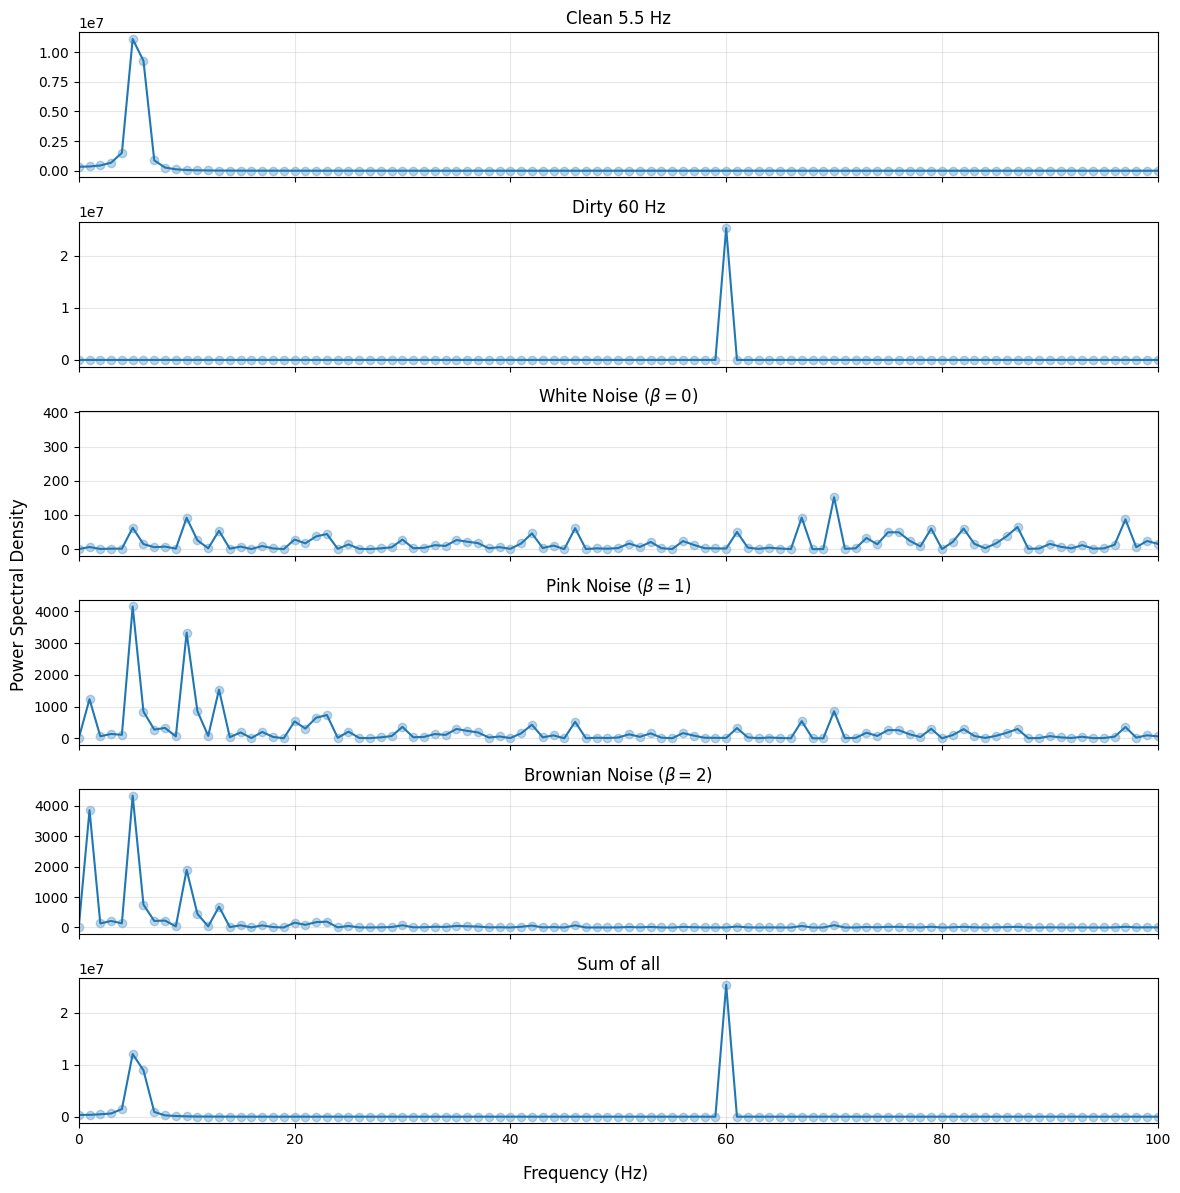

In [ ]:
# FFT and plotting power spectrum

def get_fourier_transform(stream, sampling_interval):
    fft = np.fft.fft(stream)

    # in order to plot the amplitudes in frequency space, we need to generate the frequency axis too
    frequencies = np.fft.fftfreq(len(stream), sampling_interval)

    # we only take the positive frequencies ( and the corresponding amplitudes)
    return frequencies[:len(frequencies)//2], np.abs(fft[:len(fft)//2])

fig, axs = plt.subplots(6,1, figsize=(12,12), sharex=True)
for index, (key, value) in enumerate(streams.items()):
    freq, fft = get_fourier_transform(stream=value, sampling_interval=sampling_interval)
    psd = fft**2 # PSD is the squared amplitude of the fourier transform
    axs[index].plot(freq,psd)
    axs[index].scatter(freq,psd, alpha=0.3)
    axs[index].set_title(key)
    axs[index].grid(alpha=0.3)
    axs[index].set_xlim([0,100]) # specifying range where interesting things happen. Can be removed to see full spectrum
    #axs[index].set_xscale("log") # you can also uncomment these lines to see these plots in log scale
    #axs[index].set_yscale("log")

fig.supxlabel("Frequency (Hz)")
fig.supylabel("Power Spectral Density")
plt.tight_layout()

For stream White Noise    | amp = 5.5262     +- 0.5953    | slope = 0.0282  +- 0.0327
For stream Pink Noise     | amp = 2114.1291  +- 227.7564  | slope = -0.9661 +- 0.0327
For stream Brownian Noise | amp = 12637.4179 +- 1361.4368 | slope = -1.9604 +- 0.0327




<ipython-input-10-64fd2ed302e9>:47: RuntimeWarning: divide by zero encountered in power
  ax.plot(freqs, amp*freqs**slope, c="hotpink", label=rf"$({amp:.2f} \pm {amp_err:.2f}) / f^{{({slope:.2f} \pm {slope_err:.2f})}}$")
<ipython-input-10-64fd2ed302e9>:54: RuntimeWarning: divide by zero encountered in power
  ax.plot(freqs, amp*freqs**slope, c="maroon", label=rf"$({amp:.2f} \pm {amp_err:.2f}) / f^{{({slope:.2f} \pm {slope_err:.2f})}}$")


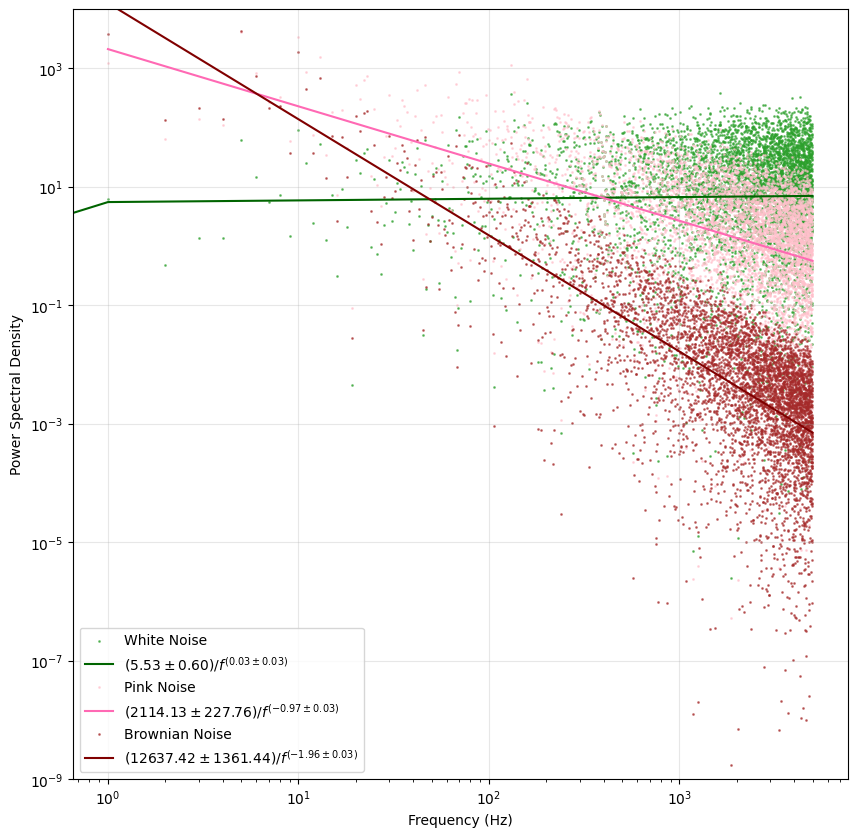

In [ ]:
def power_law_fit(psd, frequencies):
    # we first convert to a linear equation
    # log(psd) = log(1) + alpha * log(frequencies)
    # we also must discard zero values (for log)
    valid_indices = (frequencies > 0) & (psd > 0)
    logx = np.log10(frequencies[valid_indices])
    logy = np.log10(psd[valid_indices])

    # then we define fitting functions
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y: (y - fitfunc(p, x))

    # define initial guess
    pinit = [1.0, -1.0]

    # then we fit
    out = optimize.leastsq(errfunc, pinit, args=(logx, logy), full_output=1)

    # get the fit result
    pfinal = out[0]
    covar = out[1]

    # extract useful information
    slope = pfinal[1]
    amp = 10.0**pfinal[0]
    slope_err = np.sqrt(covar[1][1])
    amp_err = np.sqrt(covar[0][0]) * amp

    return slope, slope_err, amp, amp_err

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale("log")
ax.set_yscale("log")

# white noise
freqs, fft = get_fourier_transform(white_noise, sampling_interval=sampling_interval)
slope, slope_err, amp, amp_err = power_law_fit(fft**2, freqs)
ax.scatter(freq, fft**2, label="White Noise",c="C2", alpha=0.6, s=1)
ax.plot(freqs, amp*freqs**slope, c="darkgreen", label=rf"$({amp:.2f} \pm {amp_err:.2f}) / f^{{({slope:.2f} \pm {slope_err:.2f})}}$")
print(f"For stream White Noise    | amp = {amp:.4f}     +- {amp_err:.4f}    | slope = {slope:.4f}  +- {slope_err:.4f}")


# pink noise
freqs, fft = get_fourier_transform(pink_noise, sampling_interval=sampling_interval)
slope, slope_err, amp, amp_err = power_law_fit(fft**2, freqs)
ax.scatter(freq, fft**2, label="Pink Noise",c="pink", alpha=0.6, s=1)
ax.plot(freqs, amp*freqs**slope, c="hotpink", label=rf"$({amp:.2f} \pm {amp_err:.2f}) / f^{{({slope:.2f} \pm {slope_err:.2f})}}$")
print(f"For stream Pink Noise     | amp = {amp:.4f}  +- {amp_err:.4f}  | slope = {slope:.4f} +- {slope_err:.4f}")

# brownian noise
freqs, fft = get_fourier_transform(brownian_noise, sampling_interval=sampling_interval)
slope, slope_err, amp, amp_err = power_law_fit(fft**2, freqs)
ax.scatter(freq, fft**2, label="Brownian Noise",c="brown", alpha=0.6, s=1)
ax.plot(freqs, amp*freqs**slope, c="maroon", label=rf"$({amp:.2f} \pm {amp_err:.2f}) / f^{{({slope:.2f} \pm {slope_err:.2f})}}$")
print(f"For stream Brownian Noise | amp = {amp:.4f} +- {amp_err:.4f} | slope = {slope:.4f} +- {slope_err:.4f}")
print("\n")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density")
ax.set_ylim([1e-9,1e4])
plt.legend()
plt.grid(alpha=0.3)

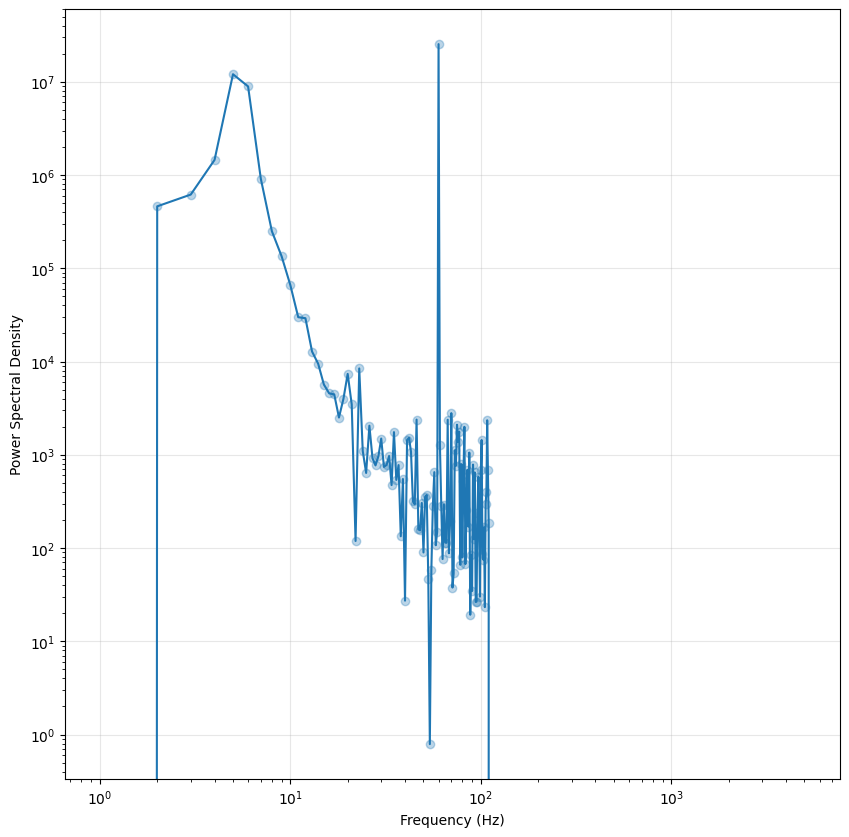

In [ ]:
def highpass_filter(freqs, psd, threshold):
    # applies a minimum frequency cutoff to the psd
    # threshold is in same units as freq (Hz)

    filtered_psd=np.copy(psd) # we make a copy to avoid messing with original array
    filtered_psd[freqs<threshold] = 0

    return filtered_psd

def lowpass_filter(freqs, psd, threshold):
    # applies a maximum frequency cutoff to the psd
    # threshold is in same units as freq (Hz)

    filtered_psd=np.copy(psd) # we make a copy to avoid messing with original array
    filtered_psd[freqs>threshold] = 0

    return filtered_psd

# applying to total timestream
freq, fft = get_fourier_transform(sum_of_all, sampling_interval=sampling_interval)
psd = fft**2
filtered_psd = highpass_filter(freq, psd, threshold=1.5)
filtered_psd = lowpass_filter(freq, filtered_psd, threshold=110)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(freq,filtered_psd)
ax.scatter(freq,filtered_psd, alpha=0.3)
#ax.set_title(key)
ax.grid(alpha=0.3)
#ax.set_xlim([0,100]) # specifying range where interesting things happen. Can be removed to see full spectrum
ax.set_xscale("log") # you can also uncomment these lines to see these plots in log scale
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density")
plt.grid(alpha=0.3)

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here:
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece)
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [16]:
# opening the maps
with fits.open("data/SPT0538-50_ALMA_870um.fits") as hdul:
    #hdul.info()
    #display(hdul[0].header)
    ALMA = hdul[0].data[0,0] # sliced to get rid of explicit dimensions
#plt.imshow(ALMA) # uncomment to plot ALMA

with fits.open("data/SPT0538-50_SPT_220GHz.fits") as hdul:
    #hdul.info()
    #display(hdul[0].header)
    SPT = hdul[0].data
#plt.imshow(SPT) # uncomment to plot SPT

with fits.open("data/DESJ053816.9-503050.8_g.fits") as hdul:
    #display(hdul.info())
    #display(hdul[0].header)
    DES_g = hdul[0].data
#plt.imshow(DES_g)

with fits.open("data/DESJ053816.9-503050.8_r.fits") as hdul:
    #display(hdul.info())
    #display(hdul[0].header)
    DES_r = hdul[0].data
#plt.imshow(DES_g)

with fits.open("data/DESJ053816.9-503050.8_i.fits") as hdul:
    #display(hdul.info())
    #display(hdul[0].header)
    DES_i = hdul[0].data
#plt.imshow(DES_g)

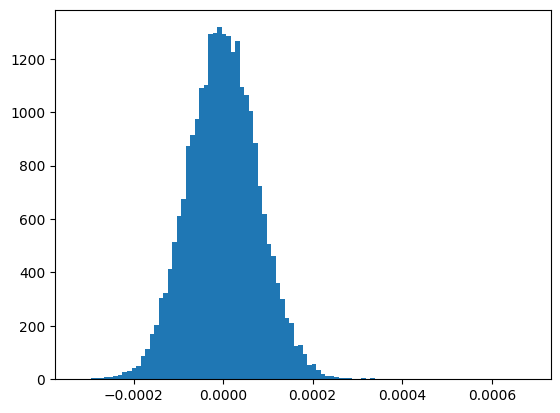

In [21]:
plt.hist(SPT.ravel(), bins=100)
plt.show()

In [43]:
#testing

In [31]:
def noise_and_SNR(map, map_name=None):
    # We interpret signal to be pixel values and noise to be the standard deviation of pixel values
    map_std = np.std(map)
    max_SN_map = np.max(map)/map_std

    # if we supply a map name, we print a string with values
    if map_name:
        print(f"For the {map_name} map, the standard deviation is {map_std} and the maximum SNR is {max_SN_map}")
    return map_std, max_SN_map

ALMA_std,max_SNR_ALMA=noise_and_SNR(ALMA, "ALMA")
SPT_std,max_SNR_STD=noise_and_SNR(SPT, "SPT")
DES_g_std,max_SNR_DES_g=noise_and_SNR(DES_g, "DES_g") # not sure if you want these too, but they are here anyway
DES_r_std,max_SNR_DES_r=noise_and_SNR(DES_r, "DES_r")
DES_i_std,max_SNR_DES_i=noise_and_SNR(DES_i, "DES_i")

For the ALMA map, the standard deviation is 0.001384946284815669 and the maximum SNR is 18.993730545043945
For the SPT map, the standard deviation is 7.949266728246585e-05 and the maximum SNR is 8.572112083435059
For the DES_g map, the standard deviation is 102.43327331542969 and the maximum SNR is 208.9929656982422
For the DES_r map, the standard deviation is 139.56825256347656 and the maximum SNR is 178.86187744140625
For the DES_i map, the standard deviation is 200.41555786132812 and the maximum SNR is 160.51150512695312


To make the rgb image, I pretty much just followed [this link](https://remoteastrophotography.com/2019/12/creating-an-rgb-image-using-saoimage-ds9).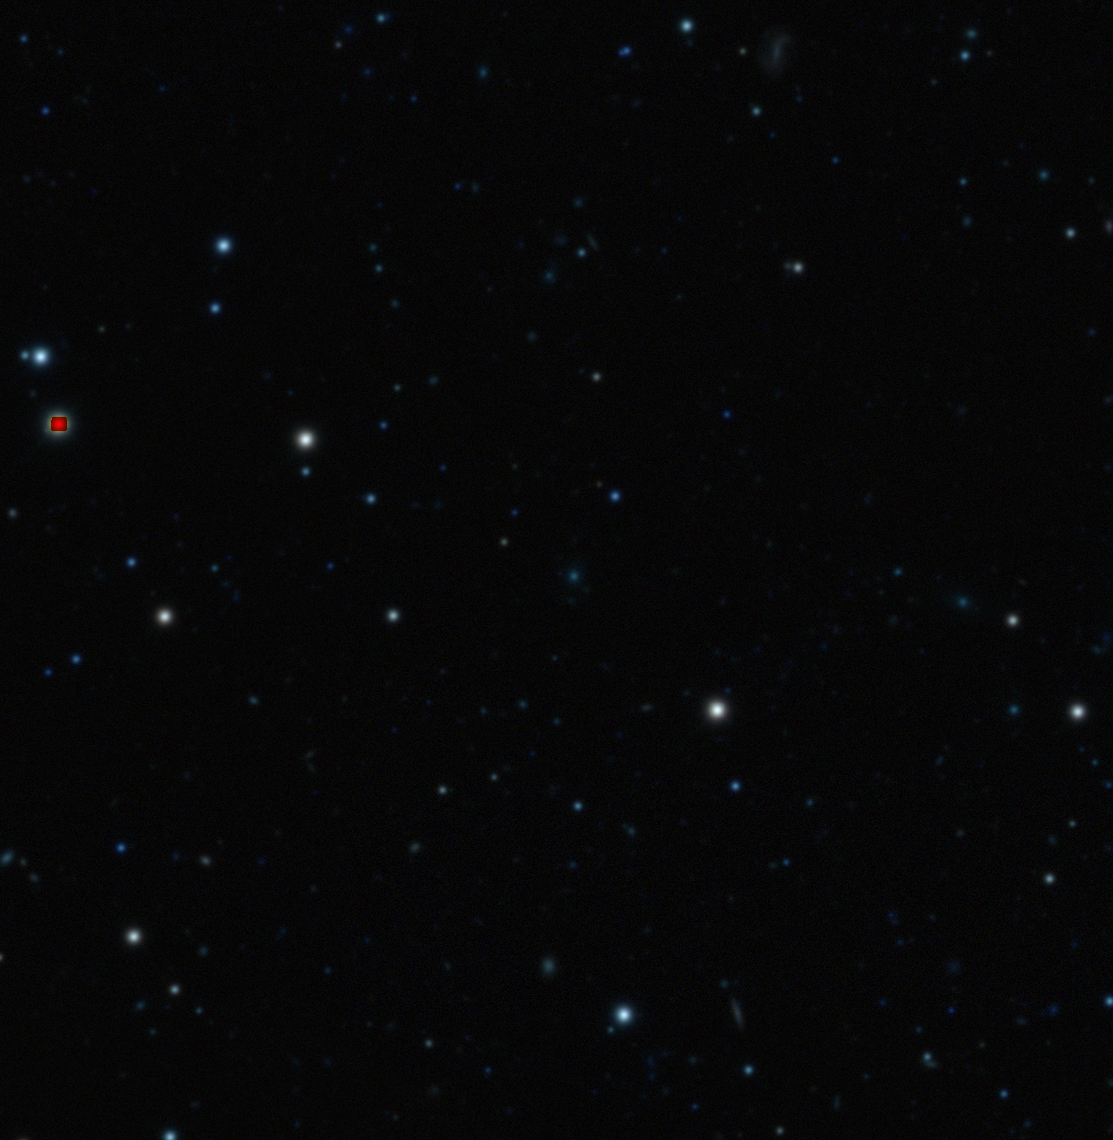

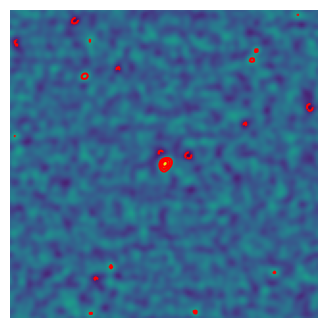

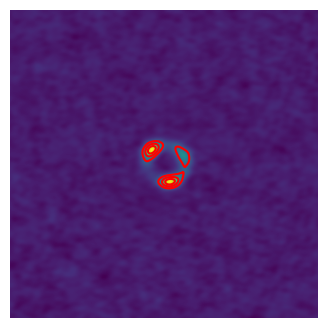

In [42]:
def get_contour_values(sigmas, image):
    '''
    returns the signal values for -s,s for each s in sigmas
    '''
    mean =np.mean(image)
    sigma=np.std(image)
    values=[]
    for s in sigmas:
        values.append(mean-sigma*s)
        values.append(mean+sigma*s)
    return np.sort(values)

get_contour_values([3,5,7,9], SPT)

def plot_with_contours(image, sigmas):
    values = get_contour_values(sigmas,image)
    fig,ax=plt.subplots(figsize=(4,4))
    ax.imshow(image,origin="lower")
    contours = plt.contour(image,levels=values,colors="red")
    plt.clabel(contours,inline=True,fontsize=8)
    ax.axis("off")

plot_with_contours(SPT,[3,5,7,9])
plot_with_contours(ALMA,[5,10,15,20])


# Q3 - Coordinates, time conversions (30 pts)

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series.

# Due Oct 22 at Noon!